In [7]:
#Importing necessary libraries 
import keras
import numpy as np
import pandas as pd
from keras.applications import vgg16, inception_v3, resnet50, mobilenet
from keras import models
from keras import layers
from keras import optimizers
import cv2
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import os

In [8]:
#Load the ResNet50 model
resnet_model = resnet50.ResNet50(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

In [9]:
# Checking the trainable status of the individual layers
for layer in resnet_model.layers:
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7f4b36f3d400> False
<keras.layers.convolutional.ZeroPadding2D object at 0x7f4b36f3d2b0> True
<keras.layers.convolutional.Conv2D object at 0x7f4b3c617d30> True
<keras.layers.normalization.BatchNormalization object at 0x7f4b0da8e6a0> True
<keras.layers.core.Activation object at 0x7f4ae8c4e9b0> True
<keras.layers.convolutional.ZeroPadding2D object at 0x7f4ae852d898> True
<keras.layers.pooling.MaxPooling2D object at 0x7f4ae89f7eb8> True
<keras.layers.convolutional.Conv2D object at 0x7f4b0daa0438> True
<keras.layers.normalization.BatchNormalization object at 0x7f4b0d1787f0> True
<keras.layers.core.Activation object at 0x7f4b0d1789b0> True
<keras.layers.convolutional.Conv2D object at 0x7f4b0d11a588> True
<keras.layers.normalization.BatchNormalization object at 0x7f4b0d0da9b0> True
<keras.layers.core.Activation object at 0x7f4b0d0f7208> True
<keras.layers.convolutional.Conv2D object at 0x7f4b0d0116a0> True
<keras.layers.convolutional.Conv2D obj

In [10]:
# Adding classifier on top of Convolutional base
# create the model
model = models.Sequential()

# Add the resnet50 convolutional model
model.add(resnet_model)

# Adding top Layers
model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(3, activation='softmax'))

# Showing summary of model
model.summary()

# Fitting the CNN to the images(Image Augmentation, Image Preprocessing)
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(  
        rescale=1./255,
        shear_range=0.2,             
        zoom_range=0.2,              
        horizontal_flip=True)


# Normalizing the test set
test_datagen = ImageDataGenerator(rescale=1./255)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2, 2, 2048)        23587712  
_________________________________________________________________
flatten_2 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              8389632   
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 3075      
Total params: 31,980,419
Trainable params: 31,927,299
Non-trainable params: 53,120
_________________________________________________________________


In [11]:
# This will create 80:20 split of training and test set 
# path to data
os.chdir('/home/sachin_sharma/Desktop/exp_2_jpg')
training_set = train_datagen.flow_from_directory(
        'TrainingSet',
         target_size=(64,64),
         batch_size=32,
         class_mode='categorical')

# This will create the Test set
test_set = test_datagen.flow_from_directory(
        'TestSet',
        target_size=(64,64),
        batch_size=32,
        class_mode='categorical', 
        shuffle=False)

# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

Found 22528 images belonging to 3 classes.
Found 6460 images belonging to 3 classes.


In [12]:
# Train the model
history = model.fit_generator(
          training_set, 
          steps_per_epoch=(training_set.samples/32),
          epochs=15,
          validation_data=test_set,
          validation_steps=(test_set.samples/32))

Epoch 1/15
704/704 [==============================] - 179s 255ms/step - loss: 0.1866 - acc: 0.9197 - val_loss: 0.1385 - val_acc: 0.9262
Epoch 2/15
704/704 [==============================] - 44s 63ms/step - loss: 0.1242 - acc: 0.9397 - val_loss: 0.1231 - val_acc: 0.9277
Epoch 3/15
704/704 [==============================] - 45s 64ms/step - loss: 0.1160 - acc: 0.9425 - val_loss: 0.2282 - val_acc: 0.9189
Epoch 4/15
704/704 [==============================] - 45s 64ms/step - loss: 0.1092 - acc: 0.9442 - val_loss: 0.3108 - val_acc: 0.9065
Epoch 5/15
704/704 [==============================] - 45s 64ms/step - loss: 0.1141 - acc: 0.9459 - val_loss: 0.1489 - val_acc: 0.9238
Epoch 6/15
704/704 [==============================] - 45s 64ms/step - loss: 0.1062 - acc: 0.9482 - val_loss: 0.1771 - val_acc: 0.9229
Epoch 7/15
704/704 [==============================] - 45s 64ms/step - loss: 0.0998 - acc: 0.9490 - val_loss: 0.1359 - val_acc: 0.9289
Epoch 8/15
704/704 [==============================] - 45s 65

In [19]:
# saving the model
os.chdir('/home/sachin_sharma/Desktop')
model.save('exp2_a1.h5')

In [13]:
# Visualizing the mapping between labels
training_set.class_indices

{'Else': 0, 'Industrial': 1, 'Residential': 2}

In [14]:
# getting predictions
Y_pred = model.predict_generator(test_set, test_set.samples//32 +1 )
y_pred = np.argmax(Y_pred, axis=1)


In [15]:
# Confusion Matrix 
print('Confusion Matrix: ')
cm = confusion_matrix(test_set.classes, y_pred)
#print(cm)

def cm2df(cm, labels):
    df = pd.DataFrame()
    # rows
    for i, row_label in enumerate(labels):
        rowdata={}
        # columns
        for j, col_label in enumerate(labels): 
            rowdata[col_label]=cm[i,j]
        df = df.append(pd.DataFrame.from_dict({row_label:rowdata}, orient='index'))
    return df[labels]

df = cm2df(cm, ["Else", "Industrial", "Residential"])
print(df)

Confusion Matrix: 
             Else  Industrial  Residential
Else         4765          31            4
Industrial      0         754            6
Residential     6         424          470


In [17]:
# Classification report
print('Classification Report')
target_names = ['Else', 'Industrial', 'Residential']
classifcn_report = classification_report(test_set.classes, y_pred, target_names=target_names)
print(classifcn_report)

Classification Report
              precision    recall  f1-score   support

        Else       1.00      0.99      1.00      4800
  Industrial       0.62      0.99      0.77       760
 Residential       0.98      0.52      0.68       900

   micro avg       0.93      0.93      0.93      6460
   macro avg       0.87      0.84      0.81      6460
weighted avg       0.95      0.93      0.92      6460



dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


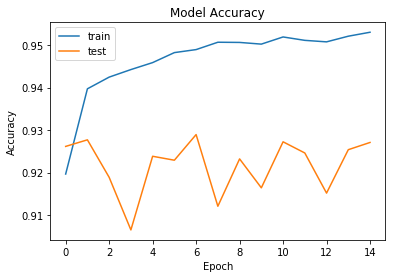

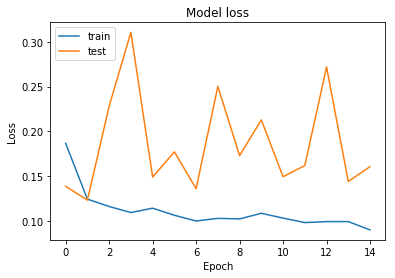

In [18]:
# Plotting the Loss and Classification Accuracy
model.metrics_names
print(history.history.keys())
#  "Accuracy"
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
